In [35]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit

import jaxley as jx
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect, connect, sparse_connect

In [36]:
comp = jx.Compartment()
branch = jx.Branch(comp, ncomp=5)

parents = jnp.asarray([-1, 0, 0])
cell = jx.Cell(branch, parents=parents)

# cell.insert(Leak())             # everywhere
# cell.branch(0).insert(Na())     # add Na/K on “soma branch”
# cell.branch(0).insert(K())


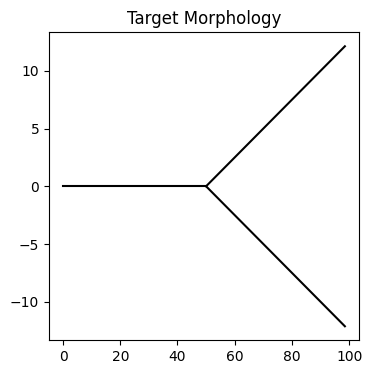

In [37]:
cell.compute_xyz()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
cell.vis(ax=ax)
ax.set_title("Target Morphology");


In [38]:
n_pre = 5
num_cells = n_pre + 1
net = jx.Network([cell for _ in range(num_cells)])

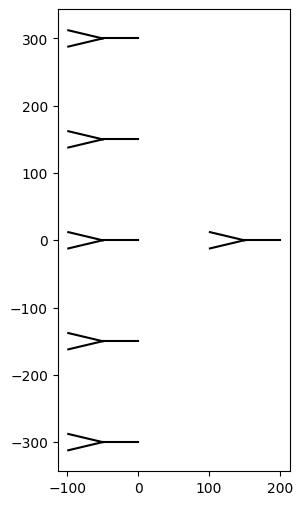

In [39]:
net.compute_xyz()
net.rotate(180)
net.arrange_in_layers(layers=[5, 1], within_layer_offset=150, between_layer_offset=200)

fig, ax = plt.subplots(1, 1, figsize=(3, 6))
_ = net.vis(ax=ax, detail="full")

In [40]:
pre = net.cell(range(n_pre))
post = net.cell(n_pre)
fully_connect(pre, post, IonotropicSynapse(),random_post_comp=False)
# net.set("IonotropicSynapse_gS", 0.0005)   # nS, tweak as needed
# sparse_connect(pre, post, IonotropicSynapse(), p=0.8, random_post_comp=True)

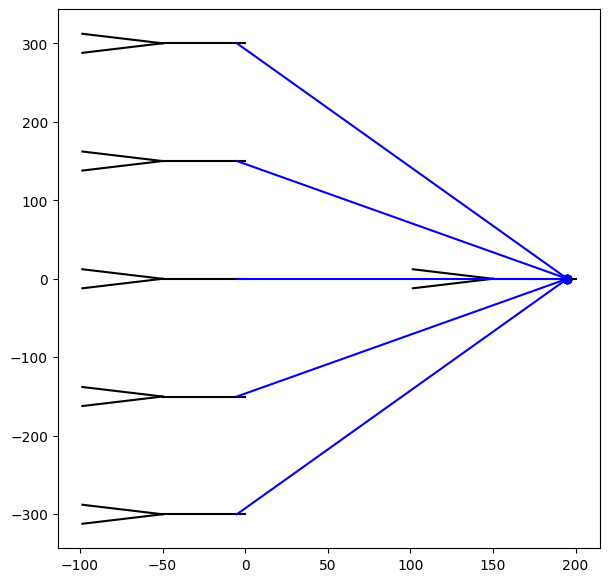

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
_ = net.vis(ax=ax, detail="full")

In [42]:
net.edges

,global_edge_index,index_within_type,pre_index,post_index,type,type_ind,pre_locs,post_locs,IonotropicSynapse_gS,IonotropicSynapse_e_syn,IonotropicSynapse_k_minus,IonotropicSynapse_v_th,IonotropicSynapse_delta,IonotropicSynapse_s,controlled_by_param
0,0,0,0,80,IonotropicSynapse,0,0.1,0.1,0.0001,0.0,0.025,-35.0,10.0,0.2,0
1,1,1,16,80,IonotropicSynapse,0,0.1,0.1,0.0001,0.0,0.025,-35.0,10.0,0.2,0
2,2,2,32,80,IonotropicSynapse,0,0.1,0.1,0.0001,0.0,0.025,-35.0,10.0,0.2,0
3,3,3,48,80,IonotropicSynapse,0,0.1,0.1,0.0001,0.0,0.025,-35.0,10.0,0.2,0
4,4,4,64,80,IonotropicSynapse,0,0.1,0.1,0.0001,0.0,0.025,-35.0,10.0,0.2,0


In [43]:
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

dt = 0.025  # ms
t_max = 50.0  # ms

In [44]:
time_vec = jnp.arange(0.0, t_max + dt, dt)

In [45]:
net.insert(Na())
net.insert(K())
net.insert(Leak())

In [46]:
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
net.delete_stimuli()
for stim_ind in range(n_pre):
    net.cell(stim_ind).branch(0).loc(0.0).stimulate(current)

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.


In [47]:
net.delete_recordings()
net.cell(5).branch(0).loc(0.0).record()


Added 1 recordings. See `.recordings` for details.


In [48]:
s = jx.integrate(net, delta_t=dt)

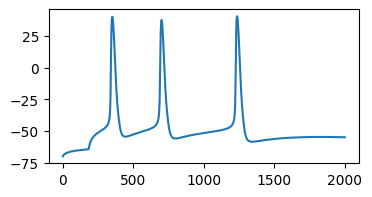

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(s.T)

TRAIN

In [50]:
from jax import jit, vmap, value_and_grad
import jaxley.optimize.transforms as jt

In [51]:
net.delete_trainables()
net.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

params_true = net.get_parameters()


Number of newly added trainable parameters: 5. Total number of trainable parameters: 5


In [52]:
transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])
opt_params_true = transform.inverse(params_true)

In [53]:
s = jx.integrate(net, params=params_true, t_max=10.0)


In [54]:
base_amp = i_amp # nA when bit = 1

def simulate(params, pattern):
    """
    pattern: (n_pre,) binary 0/1
    returns: soma trace (timepoints,)
    """
    # pattern scales the step amplitudes
    amps = base_amp * pattern  # (n_pre,)

    # Jaxley helper: gives one step-current trace per input dimension
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur,
        i_amp=amps,
        delta_t=dt, t_max=t_max
    )  # shape (n_pre, T)

    # Build data_stimuli for this pattern
    data_stimuli = None
    for i in range(n_pre):
        data_stimuli = net.cell(i).branch(0).loc(0.0).data_stimulate(
            currents[i], data_stimuli=data_stimuli
        )

    # Run network with *given* params
    traces = jx.integrate(
        net,
        params=params,
        data_stimuli=data_stimuli,
        delta_t=dt,
    )  # shape (num_recordings, T)

    # We should have recorded only the postsyn soma
    soma_trace = traces[0]  # (T,)
    return soma_trace

# Batched version over many patterns
batched_simulate = vmap(simulate, in_axes=(None, 0))  # params shared, patterns batched


In [55]:
import jax

In [56]:
key = jax.random.PRNGKey(0)
n_samples = 200   # total dataset size

patterns = jax.random.bernoulli(key, p=0.5, shape=(n_samples, n_pre))
patterns = patterns.astype(jnp.float64)

params_true = transform.forward(opt_params_true)

targets = batched_simulate(params_true, patterns)

In [57]:
split = int(0.8 * n_samples)
patterns_train = patterns[:split]
targets_train  = targets[:split]
patterns_val   = patterns[split:]
targets_val    = targets[split:]

START SANITY CHECKS FOR MY SANITY

pattern_example shape: (5,)


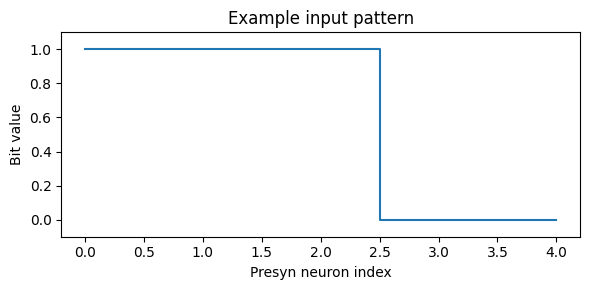

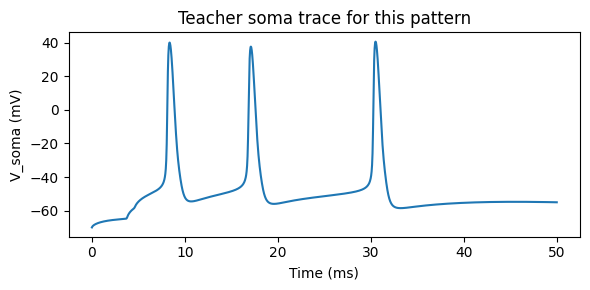

In [58]:
idx = 500
pattern_example = patterns[idx]
target_example  = targets[idx]   # shape (T,)
print("pattern_example shape:", pattern_example.shape)

# time axis from dt and T
T = target_example.shape[0]
time_vec = jnp.arange(T) * dt

plt.figure(figsize=(6, 3))
plt.step(range(n_pre), pattern_example, where="mid")
plt.ylim(-0.1, 1.1)
plt.xlabel("Presyn neuron index")
plt.ylabel("Bit value")
plt.title("Example input pattern")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(time_vec, target_example)
plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher soma trace for this pattern")
plt.tight_layout()
plt.show()


In [59]:
print("patterns.shape:", patterns.shape)
print("targets.shape:", targets.shape)

idx = 500
print("Trying idx =", idx)

pattern_example = patterns[idx]
target_example  = targets[idx]
print("pattern_example shape:", pattern_example.shape)
print("target_example shape:", target_example.shape)


patterns.shape: (200, 5)
targets.shape: (200, 2002)
Trying idx = 500
pattern_example shape: (5,)
target_example shape: (2002,)


In [60]:
print("patterns.shape:", patterns.shape)
print("targets.shape:", targets.shape)

idx = 500
print("Trying idx =", idx)

pattern_example = patterns[idx]
target_example  = targets[idx]

print("pattern_example shape:", pattern_example.shape)
print("target_example shape:", target_example.shape)
print("pattern_example:", pattern_example)


patterns.shape: (200, 5)
targets.shape: (200, 2002)
Trying idx = 500
pattern_example shape: (5,)
target_example shape: (2002,)
pattern_example: [1. 1. 1. 0. 0.]


In [61]:
print("patterns[195]:", patterns[195])
print("patterns[196]:", patterns[196])
print("patterns[197]:", patterns[197])
print("patterns[198]:", patterns[198])

patterns[195]: [0. 0. 0. 0. 1.]
patterns[196]: [1. 1. 1. 1. 1.]
patterns[197]: [0. 0. 0. 0. 1.]
patterns[198]: [0. 1. 1. 1. 0.]


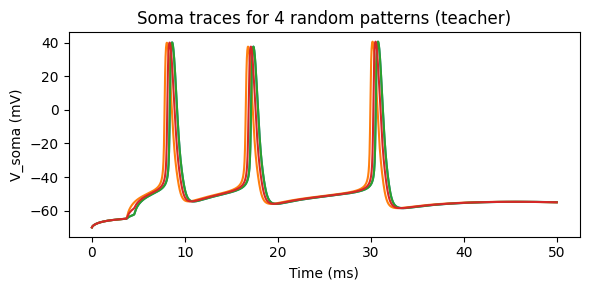

In [62]:
# run a small batch
traces = batched_simulate(params_true, patterns[195:199])  # (4, T)

T = traces.shape[1]
time_vec = jnp.arange(T) * dt

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces.T)   # traces.T has shape (T, 4)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.set_title("Soma traces for 4 random patterns (teacher)")
plt.tight_layout()
plt.show()


In [63]:
traces = batched_simulate(params_true, patterns[195:199])
max_diff = jnp.max(jnp.abs(traces[0] - traces[1]))
print("max |difference| between trace 0 and 1:", float(max_diff))


max |difference| between trace 0 and 1: 83.02059430391705


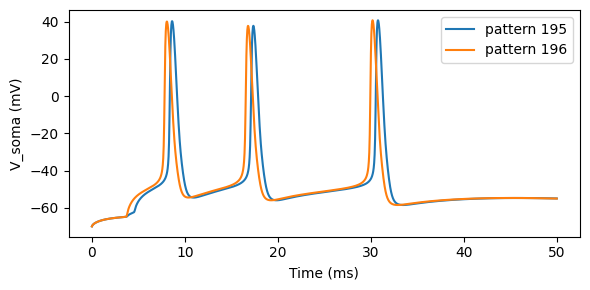

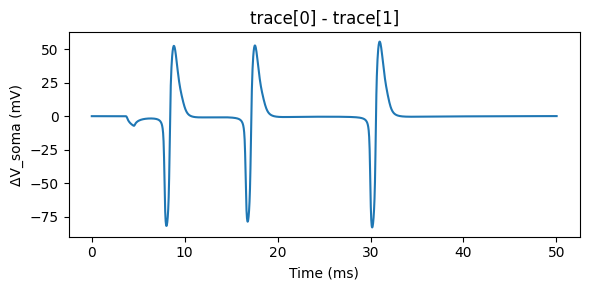

In [64]:
T = traces.shape[1]
time_vec = jnp.arange(T) * dt

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces[0], label="pattern 195")
ax.plot(time_vec, traces[1], label="pattern 196")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, traces[0] - traces[1])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("ΔV_soma (mV)")
ax.set_title("trace[0] - trace[1]")
plt.tight_layout()
plt.show()


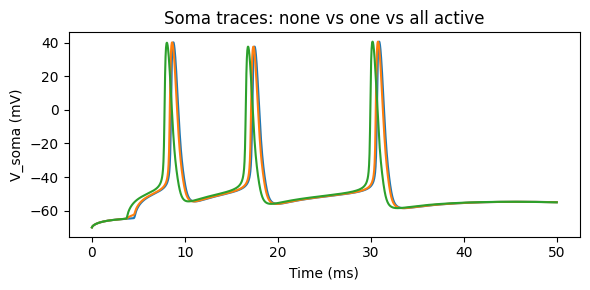

In [65]:
# Make some hand-crafted patterns
p_none = jnp.array([0, 0, 0, 0, 0.], dtype=jnp.float64)
p_one  = jnp.array([1, 0, 0, 0, 0.], dtype=jnp.float64)
p_all  = jnp.array([1, 1, 1, 1, 1.], dtype=jnp.float64)

ext_patterns = jnp.stack([p_none, p_one, p_all], axis=0)
ext_traces   = batched_simulate(params_true, ext_patterns)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time_vec, ext_traces.T)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V_soma (mV)")
ax.set_title("Soma traces: none vs one vs all active")
plt.tight_layout()
plt.show()


SANITY DONE

TRAIN

In [66]:
# --- learner initialization (in transformed space) ---
key_learn = jax.random.PRNGKey(1)
noise_scale = 0.3  # you can tune this

def add_noise_to_opt_params(opt_params, key, scale):
    leaves, treedef = jax.tree_util.tree_flatten(opt_params)
    subkeys = jax.random.split(key, len(leaves))
    noisy_leaves = [
        p + scale * jax.random.normal(k, p.shape)
        for p, k in zip(leaves, subkeys)
    ]
    return jax.tree_util.tree_unflatten(treedef, noisy_leaves)

opt_params_learn = add_noise_to_opt_params(opt_params_true, key_learn, noise_scale)


In [67]:
def loss_fn(opt_params, patterns_batch, targets_batch):
    params = transform.forward(opt_params)
    preds = batched_simulate(params, patterns_batch)   # (B, T)
    return jnp.mean((preds - targets_batch) ** 2)

grad_fn = jit(value_and_grad(loss_fn, argnums=0))


In [69]:
import optax

learning_rate = 1e-2
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(opt_params_learn)

num_steps = 300
print_every = 20

for step in range(num_steps + 1):
    train_loss, grads = grad_fn(opt_params_learn, patterns_train, targets_train)
    updates, opt_state = optimizer.update(grads, opt_state, opt_params_learn)
    opt_params_learn = optax.apply_updates(opt_params_learn, updates)

    if step % print_every == 0:
        # validation loss (no grad, no jit needed)
        val_loss = loss_fn(opt_params_learn, patterns_val, targets_val)
        print(f"step {step:4d} | train_loss={float(train_loss):.4e} "
              f"| val_loss={float(val_loss):.4e}")


2025-12-03 23:06:27.790572: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.68GiB (rounded to 20057428224)requested by op 
2025-12-03 23:06:27.790682: W external/tsl/tsl/framework/bfc_allocator.cc:497] **____*_____________________________________________________________________________________________
2025-12-03 23:06:27.792093: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2716] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20057428072 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.45MiB
              constant allocation:    93.4KiB
        maybe_live_out allocation:        64B
     preallocated temp allocation:   18.68GiB
                 total allocation:   18.68GiB
Peak buffers:
	Buffer 1:
		Size: 439.67MiB
		XLA Label: fusion
		Shape: f64[2001,160,2,90]

	Buffer 2:
		Size: 439.67MiB
		Operator: op_name="jit(lo

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20057428072 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.45MiB
              constant allocation:    93.4KiB
        maybe_live_out allocation:        64B
     preallocated temp allocation:   18.68GiB
                 total allocation:   18.68GiB
Peak buffers:
	Buffer 1:
		Size: 439.67MiB
		XLA Label: fusion
		Shape: f64[2001,160,2,90]
		==========================

	Buffer 2:
		Size: 439.67MiB
		Operator: op_name="jit(loss_fn)/jit(main)/broadcast_in_dim[shape=(2001, 160, 2, 90) broadcast_dimensions=()]" source_file="/tmp/ipykernel_557725/1593756083.py" source_line=26
		XLA Label: fusion
		Shape: f64[2001,160,2,90]
		==========================

	Buffer 3:
		Size: 236.93MiB
		XLA Label: fusion
		Shape: f64[2001,160,97]
		==========================

	Buffer 4:
		Size: 236.93MiB
		XLA Label: fusion
		Shape: f64[2001,160,97]
		==========================

	Buffer 5:
		Size: 236.93MiB
		XLA Label: fusion
		Shape: f64[2001,160,97]
		==========================

	Buffer 6:
		Size: 236.93MiB
		XLA Label: fusion
		Shape: f64[2001,160,97]
		==========================

	Buffer 7:
		Size: 236.93MiB
		XLA Label: fusion
		Shape: f64[2001,160,97]
		==========================

	Buffer 8:
		Size: 236.93MiB
		XLA Label: fusion
		Shape: f64[2001,160,97]
		==========================

	Buffer 9:
		Size: 236.93MiB
		XLA Label: fusion
		Shape: f64[2001,160,97]
		==========================

	Buffer 10:
		Size: 236.93MiB
		XLA Label: fusion
		Shape: f64[2001,160,97]
		==========================

	Buffer 11:
		Size: 236.93MiB
		XLA Label: fusion
		Shape: f64[2001,160,97]
		==========================

	Buffer 12:
		Size: 236.93MiB
		XLA Label: fusion
		Shape: f64[2001,160,97]
		==========================

	Buffer 13:
		Size: 236.93MiB
		XLA Label: fusion
		Shape: f64[2001,160,97]
		==========================

	Buffer 14:
		Size: 236.93MiB
		XLA Label: fusion
		Shape: f64[2001,160,97]
		==========================

	Buffer 15:
		Size: 236.93MiB
		Operator: op_name="jit(loss_fn)/jit(main)/broadcast_in_dim[shape=(2001, 160, 97) broadcast_dimensions=()]" source_file="/tmp/ipykernel_557725/1593756083.py" source_line=26
		XLA Label: fusion
		Shape: f64[2001,160,97]
		==========================



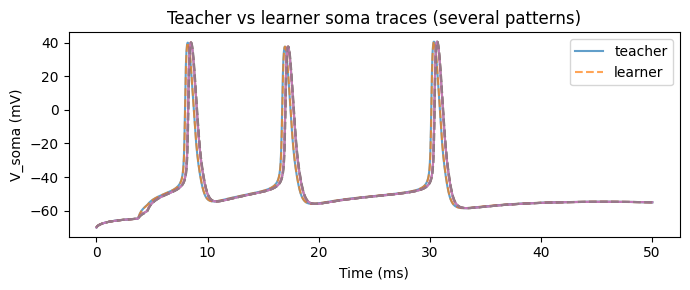

In [ ]:
idxs = jnp.array([0, 1, 2, 3])  # any 4 indices < patterns_val.shape[0]

patterns_ex = patterns_val[idxs]       # (4, n_pre)
targets_ex  = targets_val[idxs]        # (4, T)


params_learn = transform.forward(opt_params_learn)


preds_ex = batched_simulate(params_learn, patterns_ex)   # (4, T)

T_ex = preds_ex.shape[1]
time_vec = jnp.arange(T_ex) * dt

plt.figure(figsize=(7, 3))
for i in range(len(idxs)):
    plt.plot(time_vec, targets_ex[i],       alpha=0.7, label="teacher" if i == 0 else None)
    plt.plot(time_vec, preds_ex[i], "--",   alpha=0.7, label="learner" if i == 0 else None)

plt.xlabel("Time (ms)")
plt.ylabel("V_soma (mV)")
plt.title("Teacher vs learner soma traces (several patterns)")
plt.legend()
plt.tight_layout()
plt.show()


GRADIENTS!

In [ ]:
params_learn_phys = transform.forward(opt_params_learn)

In [ ]:
def simulate(params_phys, pattern):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur,
        i_amp=amps, delta_t=dt, t_max=t_max
    )
    data_stimuli = None
    for i in range(n_pre):
        data_stimuli = net.cell(i).branch(0).loc(0.0).data_stimulate(
            currents[i], data_stimuli=data_stimuli
        )

    traces = jx.integrate(
        net,
        params=params_phys,
        data_stimuli=data_stimuli,
        delta_t=dt,
    )
    soma_trace = traces[0]
    return soma_trace


In [ ]:
def single_loss_phys(params_phys, pattern, target_trace):
    pred = simulate(params_phys, pattern)   # uses params_phys directly now
    return jnp.mean((pred - target_trace) ** 2)


In [ ]:
idx = 0 
pattern_ex = patterns_val[idx]
target_ex  = targets_val[idx]    

loss_val, grads_phys = value_and_grad(single_loss_phys)(
    params_learn_phys, pattern_ex, target_ex
)

print("single-example loss:", float(loss_val))

# gradient wrt synaptic conductances
gS_grad = grads_phys[0]["IonotropicSynapse_gS"]   # ndarray
print("gS_grad shape:", gS_grad.shape)
print("gS_grad (first few):", gS_grad[:10])

gS_learn = params_learn_phys[0]["IonotropicSynapse_gS"]
print("gS_learn shape:", gS_learn.shape)
print("gS_learn (first few):", gS_learn[:10])


single-example loss: 0.285000307727783
gS_grad shape: (5,)
gS_grad (first few): [-3612381.60153233 -3676545.96328125 -3676545.96328125 -3676545.96328125
 -3676545.96328125]
gS_learn shape: (5,)
gS_learn (first few): [1.09287507e-04 1.26896324e-04 7.86322704e-05 8.34437222e-05
 1.01748074e-04]
